In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class SimpleGrid(gym.Env):
    
    def __init__(self, size = 5):

        super(SimpleGrid, self).__init__()
        self.size = size
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.MultiDiscrete([size, size])
        
        self.agent_pos = None
        self.goal_pos = None
    
    def reset(self, *, seed=None, options=None):

        super().reset(seed=seed)
        self.agent_pos = np.random.randint(0, self.size, size=2)
        self.goal_pos = np.array([self.size - 1, self.size - 1])
        while np.array_equal(self.agent_pos, self.goal_pos):
            self.goal_pos = np.random.randint(0, self.size, size=2)

        return self.agent_pos, {}
    
    def step(self, action):

        reward = 0
        x, y = self.agent_pos
        teleported = False

        if action == 0: # up
            y = min(self.size - 1, y + 1)
        elif action == 1: # down
            y = max(0, y-1)
        elif action == 2: # left
            x = max(0, x-1)
        elif action == 3: # right
            x = min(self.size - 1, x + 1)
        elif action == 4: # 
            y, x = x, y
            teleported = True
            reward -= 0.3
        elif action == 5:
            y, x = self.size - 1 - x, self.size - 1 - y
            teleported = True
            reward -= 0.3
        
        self.agent_pos = np.array([x, y])

        done = np.array_equal(self.agent_pos, self.goal_pos)

        if done:
            reward += 1.0
        else:
            reward -= 0.1

        info = {"teleported" : teleported}
        return self.agent_pos, reward, done, False, info
    
    def render(self):

        grid = np.full((self.size, self.size), ".", dtype=str)

        gx, gy = self.goal_pos
        grid[self.size - 1 - gy, gx] = "G"

        x, y = self.agent_pos
        grid[self.size - 1 - y, x] = "A"

        print("\n".join(" ".join(row) for  row in grid))
        print()


Q = np.zeros((5, 5, 6))

alpha = 0.1
gamma = 0.99
epsilon = 0.1
episodes = 1000

ep_rewards = []
env = SimpleGrid(size=5)
for i in range(episodes):
    state, info = env.reset()
    # env.render()
    done = False
    ep_reward = 0
    teleport_count = 0
    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state[0], state[1], :])

        next_state, reward, done, trunc, info = env.step(action)

        if info["teleported"]:
            teleport_count += 1

        ep_reward += reward
        Q[state[0], state[1], action] = ((1 - alpha) * Q[state[0], state[1], action] + alpha * 
                                         (reward + gamma * np.max(Q[next_state[0], next_state[1], :])))
        
        state = next_state
    ep_rewards.append(ep_reward)
    if i % 100 == 0:
        avg = np.mean(ep_rewards[-100:])
        print(f"Episode {i}, avg_reward={avg:.2f}, epsilon={epsilon:.3f}, teleports = {teleport_count}")
print("total reward: ", ep_rewards)

Episode 0, avg_reward=-3.10, epsilon=0.100, teleports = 3
Episode 100, avg_reward=-4.37, epsilon=0.100, teleports = 5
Episode 200, avg_reward=-4.46, epsilon=0.100, teleports = 2
Episode 300, avg_reward=-5.05, epsilon=0.100, teleports = 3
Episode 400, avg_reward=-4.23, epsilon=0.100, teleports = 1
Episode 500, avg_reward=-5.13, epsilon=0.100, teleports = 3
Episode 600, avg_reward=-4.20, epsilon=0.100, teleports = 1
Episode 700, avg_reward=-4.77, epsilon=0.100, teleports = 1
Episode 800, avg_reward=-4.68, epsilon=0.100, teleports = 1
Episode 900, avg_reward=-4.34, epsilon=0.100, teleports = 2
total reward:  [-3.1000000000000005, -1.2000000000000006, -17.300000000000004, -1.5000000000000004, -0.40000000000000013, -0.19999999999999996, -12.199999999999983, 0.7, 0.7, -7.499999999999991, -5.0, -4.899999999999996, -1.4000000000000008, 0.9, -5.699999999999992, 0.4, -1.4000000000000008, -3.4000000000000012, -7.499999999999993, 0.4, -4.1000000000000005, -19.000000000000014, 0.8, -5.5999999999999

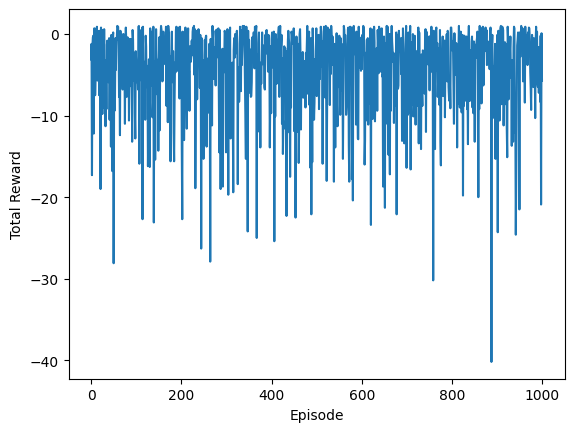

In [25]:
import matplotlib.pyplot as plt
plt.plot(ep_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()